# **PCOS Lifestyle Impact Prediction with Gradio Interface**
# This notebook implements a series of machine learning models to predict the likelihood of PCOS based on lifestyle factors. 
# The models include Random Forest, Decision Trees, Logistic Regression, and MLP.
# We also use Gradio to provide real-time predictions and visualize the results interactively.

# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, \
    classification_report, precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import gradio as gr

In [2]:
# **Load the Dataset**
df = pd.read_csv('input/Cleaned-Data.csv')
print("Initial dataset shape:", df.shape)

Initial dataset shape: (173, 36)


In [3]:
# **Data Preprocessing and Validation**
df.describe(), df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 36 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         173 non-null    object 
 1   Weight_kg                   173 non-null    float64
 2   Height_ft                   173 non-null    float64
 3   Marital_Status              173 non-null    object 
 4   PCOS                        173 non-null    object 
 5   Family_History_PCOS         173 non-null    object 
 6   Menstrual_Irregularity      173 non-null    object 
 7   Hormonal_Imbalance          173 non-null    object 
 8   Hyperandrogenism            173 non-null    object 
 9   Hirsutism                   173 non-null    object 
 10  Mental_Health               173 non-null    object 
 11  Conception_Difficulty       173 non-null    object 
 12  Insulin_Resistance          173 non-null    object 
 13  Diabetes                    173 non

(        Weight_kg   Height_ft  Diet_Bread_Cereals  Diet_Milk_Products  \
 count  173.000000  173.000000          173.000000          173.000000   
 mean    56.549711  160.636647            5.445087            3.647399   
 std     12.025369    7.287373            2.116832            2.548930   
 min     36.000000  124.460000            0.000000            0.000000   
 25%     49.000000  157.480000            4.000000            1.000000   
 50%     55.000000  160.020000            7.000000            3.000000   
 75%     64.000000  165.100000            7.000000            7.000000   
 max    115.000000  182.880000            7.000000            7.000000   
 
        Diet_Fruits  Diet_Vegetables  Diet_Starchy_Vegetables  \
 count   173.000000       173.000000               173.000000   
 mean      3.034682         3.439306                 3.069364   
 std       2.048527         1.769596                 1.857054   
 min       0.000000         0.000000                 0.000000   
 25%   

In [4]:
# Check for missing values in the target column ('PCOS')
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Age                           0
Weight_kg                     0
Height_ft                     0
Marital_Status                0
PCOS                          0
Family_History_PCOS           0
Menstrual_Irregularity        0
Hormonal_Imbalance            0
Hyperandrogenism              0
Hirsutism                     0
Mental_Health                 0
Conception_Difficulty         0
Insulin_Resistance            0
Diabetes                      0
Childhood_Trauma              0
Cardiovascular_Disease        0
Diet_Bread_Cereals            0
Diet_Milk_Products            0
Diet_Fruits                   0
Diet_Vegetables               0
Diet_Starchy_Vegetables       0
Diet_NonStarchy_Vegetables    0
Diet_Fats                     0
Diet_Sweets                   0
Diet_Fried_Food               0
Diet_Tea_Coffee               0
Diet_Multivitamin             0
Vegetarian                    0
Exercise_Frequency            0
Exercise_Type                 0
Exercise_Dur

In [5]:
# Impute missing values for numerical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy='median')
df[numerical_cols] = imputer.fit_transform(df[numerical_cols])

In [6]:
# Check again after imputation
print("\nMissing values after imputation:")
print(df.isnull().sum())


Missing values after imputation:
Age                           0
Weight_kg                     0
Height_ft                     0
Marital_Status                0
PCOS                          0
Family_History_PCOS           0
Menstrual_Irregularity        0
Hormonal_Imbalance            0
Hyperandrogenism              0
Hirsutism                     0
Mental_Health                 0
Conception_Difficulty         0
Insulin_Resistance            0
Diabetes                      0
Childhood_Trauma              0
Cardiovascular_Disease        0
Diet_Bread_Cereals            0
Diet_Milk_Products            0
Diet_Fruits                   0
Diet_Vegetables               0
Diet_Starchy_Vegetables       0
Diet_NonStarchy_Vegetables    0
Diet_Fats                     0
Diet_Sweets                   0
Diet_Fried_Food               0
Diet_Tea_Coffee               0
Diet_Multivitamin             0
Vegetarian                    0
Exercise_Frequency            0
Exercise_Type                 0
Exerci

In [7]:
# **Handle Categorical Variables**
# Label encode target column 'PCOS' as 1 and 0
df['PCOS'] = df['PCOS'].map({'Yes': 1, 'No': 0})

In [8]:
# Impute missing values for categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if df[col].isnull().sum() > 0:
        df[col].fillna(df[col].mode()[0], inplace=True) 

In [9]:
# Use LabelEncoder to encode categorical columns
data_encoded = df.copy()
le = LabelEncoder()
for col in categorical_cols:
    if col != 'PCOS':  # Skip target column
        data_encoded[col] = le.fit_transform(data_encoded[col])

In [10]:
# **Feature Engineering**
# Calculate BMI
df['Height_m'] = df['Height_ft'] * 0.3048  # Convert height to meters
df['BMI'] = df['Weight_kg'] / (df['Height_m'] ** 2)

In [11]:
# Nutritional Score based on diet columns
nutrition_weights = {
    'Diet_Bread_Cereals': 1,
    'Diet_Milk_Products': 1,
    'Diet_Fruits': 2,
    'Diet_Vegetables': 2,
    'Diet_Starchy_Vegetables': -1,
    'Diet_NonStarchy_Vegetables': 2,
    'Diet_Fats': -2,
    'Diet_Sweets': -3,
    'Diet_Fried_Food': -3,
    'Diet_Tea_Coffee': 0,
}
df['Nutritional_Score'] = df[nutrition_weights.keys()].dot(pd.Series(nutrition_weights))

In [12]:
# **Data Splitting**
features = data_encoded.drop(columns=['PCOS'])
target = data_encoded['PCOS']

In [13]:
# Check for NaN values in the target variable (PCOS)
print("\nChecking for NaN values in target variable 'PCOS':")
print(target.isnull().sum())


Checking for NaN values in target variable 'PCOS':
1


In [14]:
# If there are any missing values, handle them explicitly
target = target.fillna(0)

In [15]:
# Stratified split to maintain class distribution
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

In [16]:
# **Feature Scaling**
scaler = StandardScaler()
numerical_cols = features.select_dtypes(include=[np.number]).columns

X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

In [17]:
# **Model Evaluation**
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(50,), max_iter=1000, random_state=42)
}

In [18]:
# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report for {name}:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.8571
Classification Report for Random Forest:
               precision    recall  f1-score   support

         0.0       0.87      0.96      0.91        27
         1.0       0.80      0.50      0.62         8

    accuracy                           0.86        35
   macro avg       0.83      0.73      0.76        35
weighted avg       0.85      0.86      0.84        35


Decision Tree Accuracy: 0.8000
Classification Report for Decision Tree:
               precision    recall  f1-score   support

         0.0       0.88      0.85      0.87        27
         1.0       0.56      0.62      0.59         8

    accuracy                           0.80        35
   macro avg       0.72      0.74      0.73        35
weighted avg       0.81      0.80      0.80        35


Logistic Regression Accuracy: 0.7714
Classification Report for Logistic Regression:
               precision    recall  f1-score   support

         0.0       0.88      0.81      0.85        27
   

In [19]:
# **Feature Importance and Visualization**
# Use Random Forest to evaluate feature importance
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [20]:
# Feature importance
feature_importance = pd.Series(rf_model.feature_importances_, index=X_train.columns)
feature_importance = feature_importance.sort_values(ascending=False)

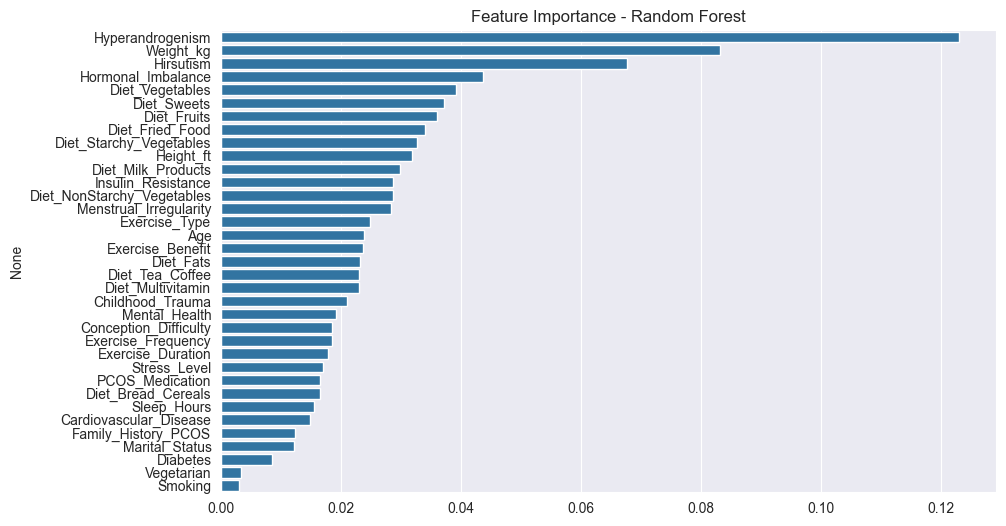

In [21]:
# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance.values, y=feature_importance.index)
plt.title("Feature Importance - Random Forest")
plt.show()

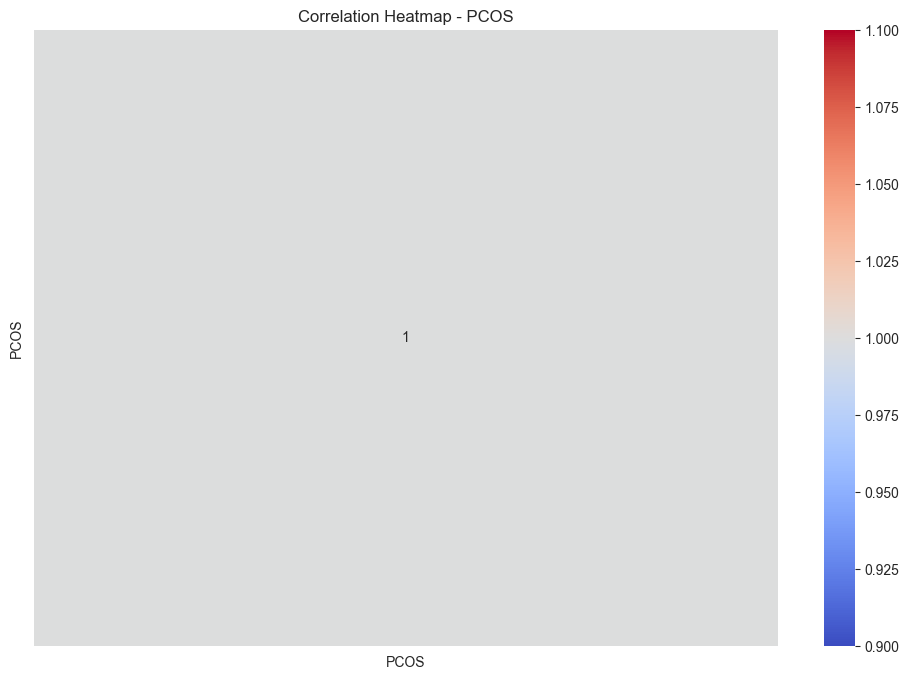

In [22]:
# **Correlation Analysis**
# Visualize correlations between features
plt.figure(figsize=(12, 8))
numerical_df = df.select_dtypes(include=['number'])
corr = numerical_df.corr()
mask = corr['PCOS'].abs() > 0.3  # Filter correlated features
sns.heatmap(corr.loc[mask, mask], annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - PCOS')
plt.show()

In [23]:
# **Model Tuning & Final Model Selection**

# Hyperparameter tuning for Random Forest (best performing model)
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

rf_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
rf_search.fit(X_train, y_train)
best_rf = rf_search.best_estimator_

In [24]:
# Evaluate the best model (best_rf)
y_pred_rf = best_rf.predict(X_test)
print("\nBest Random Forest Test Accuracy:", accuracy_score(y_test, y_pred_rf))
print(f"Classification Report for Best Random Forest:\n", classification_report(y_test, y_pred_rf))


Best Random Forest Test Accuracy: 0.8285714285714286
Classification Report for Best Random Forest:
               precision    recall  f1-score   support

         0.0       0.86      0.93      0.89        27
         1.0       0.67      0.50      0.57         8

    accuracy                           0.83        35
   macro avg       0.76      0.71      0.73        35
weighted avg       0.82      0.83      0.82        35



In [25]:
# Define the explainer for SHAP
import shap

# Initialize the SHAP explainer for Random Forest
explainer = shap.TreeExplainer(best_rf)

# Define the features variable (X) from your training data
X = features  # Use the features DataFrame for the input data

# Function to preprocess input and match the model's training features
def preprocess_input(age, weight, height, menstrual_irregularity, exercise_freq):
    # Create DataFrame from inputs
    input_df = pd.DataFrame([{
        'Age': age,
        'Weight_kg': weight,
        'Height_m': height / 100,  # Convert cm to meters
        'Menstrual_Irregularity': 1 if menstrual_irregularity else 0,
        'Exercise_Frequency': exercise_freq
    }])
    
    # Add missing features with median values
    for col in X.columns:
        if col not in input_df.columns:
            input_df[col] = df[col].median()
    
    # Reorder columns to match the training data
    input_df = input_df[X.columns]
    
    # Scale features
    scaled_input = scaler.transform(input_df)
    return scaled_input

# Function to predict PCOS risk
def predict_pcos(age, weight, height_cm, menstrual_irregular, exercise_freq):
    processed_input = preprocess_input(age, weight, height_cm, 
                                      menstrual_irregular, exercise_freq)
    prediction = best_rf.predict_proba(processed_input, verbose=0)[0][1]
    explanation = "Factors contributing to this prediction:\n"
    
    # Generate SHAP explanation
    shap_values = explainer.shap_values(processed_input)
    feature_importance = sorted(zip(X.columns, shap_values[0][0]), 
                               key=lambda x: abs(x[1]), reverse=True)[:3]
    
    for feature, value in feature_importance:
        explanation += f"- {feature}: {value:.2f}\n"
    
    lifestyle_tips = []
    if prediction > 0.7:
        lifestyle_tips.append("Consider consulting an endocrinologist")
    if weight > 70:
        lifestyle_tips.append("Weight management may help reduce symptoms")
    
    return {
        "Risk Probability": float(prediction),
        "Explanation": explanation,
        "Lifestyle Tips": "\n".join(lifestyle_tips) if lifestyle_tips else "No specific recommendations"
    }

# Gradio interface
iface = gr.Interface(fn=predict_pcos,
                     inputs=[gr.Slider(15, 45, step=1, label="Age"),
                             gr.Slider(30, 120, step=0.5, label="Weight (kg)"),
                             gr.Slider(140, 190, step=1, label="Height (cm)"),
                             gr.Radio(["Yes", "No"], label="Menstrual Irregularity"),
                             gr.Dropdown(["Daily", "3-4 Times a Week", "1-2 Times a Week", "Rarely", "Never"], 
                                         label="Exercise Frequency")
                     ],
                     outputs=["json", "text", "text"],
                     title="PCOS Risk Assessment System")

iface.launch(debug=True, inline=True)


* Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "F:\ICBT_BSCE\ASSIGNMENTS\Computational_Intelligence\PCOSPrediction\PCOS-Project\.venv\lib\site-packages\gradio\queueing.py", line 625, in process_events
    response = await route_utils.call_process_api(
  File "F:\ICBT_BSCE\ASSIGNMENTS\Computational_Intelligence\PCOSPrediction\PCOS-Project\.venv\lib\site-packages\gradio\route_utils.py", line 322, in call_process_api
    output = await app.get_blocks().process_api(
  File "F:\ICBT_BSCE\ASSIGNMENTS\Computational_Intelligence\PCOSPrediction\PCOS-Project\.venv\lib\site-packages\gradio\blocks.py", line 2098, in process_api
    result = await self.call_function(
  File "F:\ICBT_BSCE\ASSIGNMENTS\Computational_Intelligence\PCOSPrediction\PCOS-Project\.venv\lib\site-packages\gradio\blocks.py", line 1645, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "F:\ICBT_BSCE\ASSIGNMENTS\Computational_Intelligence\PCOSPrediction\PCOS-Project\.venv\lib\site-packages\anyio\

Keyboard interruption in main thread... closing server.
